In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import os
os.chdir('/content/drive/MyDrive/')
print(os.listdir('data'))

['color150.mat', 'object150_info.csv', 'training.odgt', 'validation.odgt', '.DS_Store', 'test-images-idx3-ubyte.gz', 'test-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz']


# Data preparation

In [4]:
import gzip
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from torch.utils.data import random_split


In [5]:
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28)
        return torch.tensor(data, dtype=torch.float32)

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
        return torch.tensor(data, dtype=torch.int64)

train_images = 'data/train-images-idx3-ubyte.gz'
train_labels = 'data/train-labels-idx1-ubyte.gz'
test_images = 'data/test-images-idx3-ubyte.gz'
test_labels = 'data/test-labels-idx1-ubyte.gz'

train_data = load_mnist_images(train_images)
train_targets = load_mnist_labels(train_labels)
test_data = load_mnist_images(test_images)
test_targets = load_mnist_labels(test_labels)

print("Train Data Shape:", train_data.shape)
print("Train Targets Shape:", train_targets.shape)
print("Test Data Shape:", test_data.shape)
print("Test Targets Shape:", test_targets.shape)

Train Data Shape: torch.Size([60000, 1, 28, 28])
Train Targets Shape: torch.Size([60000])
Test Data Shape: torch.Size([10000, 1, 28, 28])
Test Targets Shape: torch.Size([10000])


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
class MNISTDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

train_dataset_whole = MNISTDataset(train_data, train_targets)
test_dataset = MNISTDataset(test_data, test_targets)

train_size = int(0.9 * len(train_dataset_whole))
val_size = len(train_dataset_whole) - train_size
train_dataset, val_dataset = random_split(train_dataset_whole, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

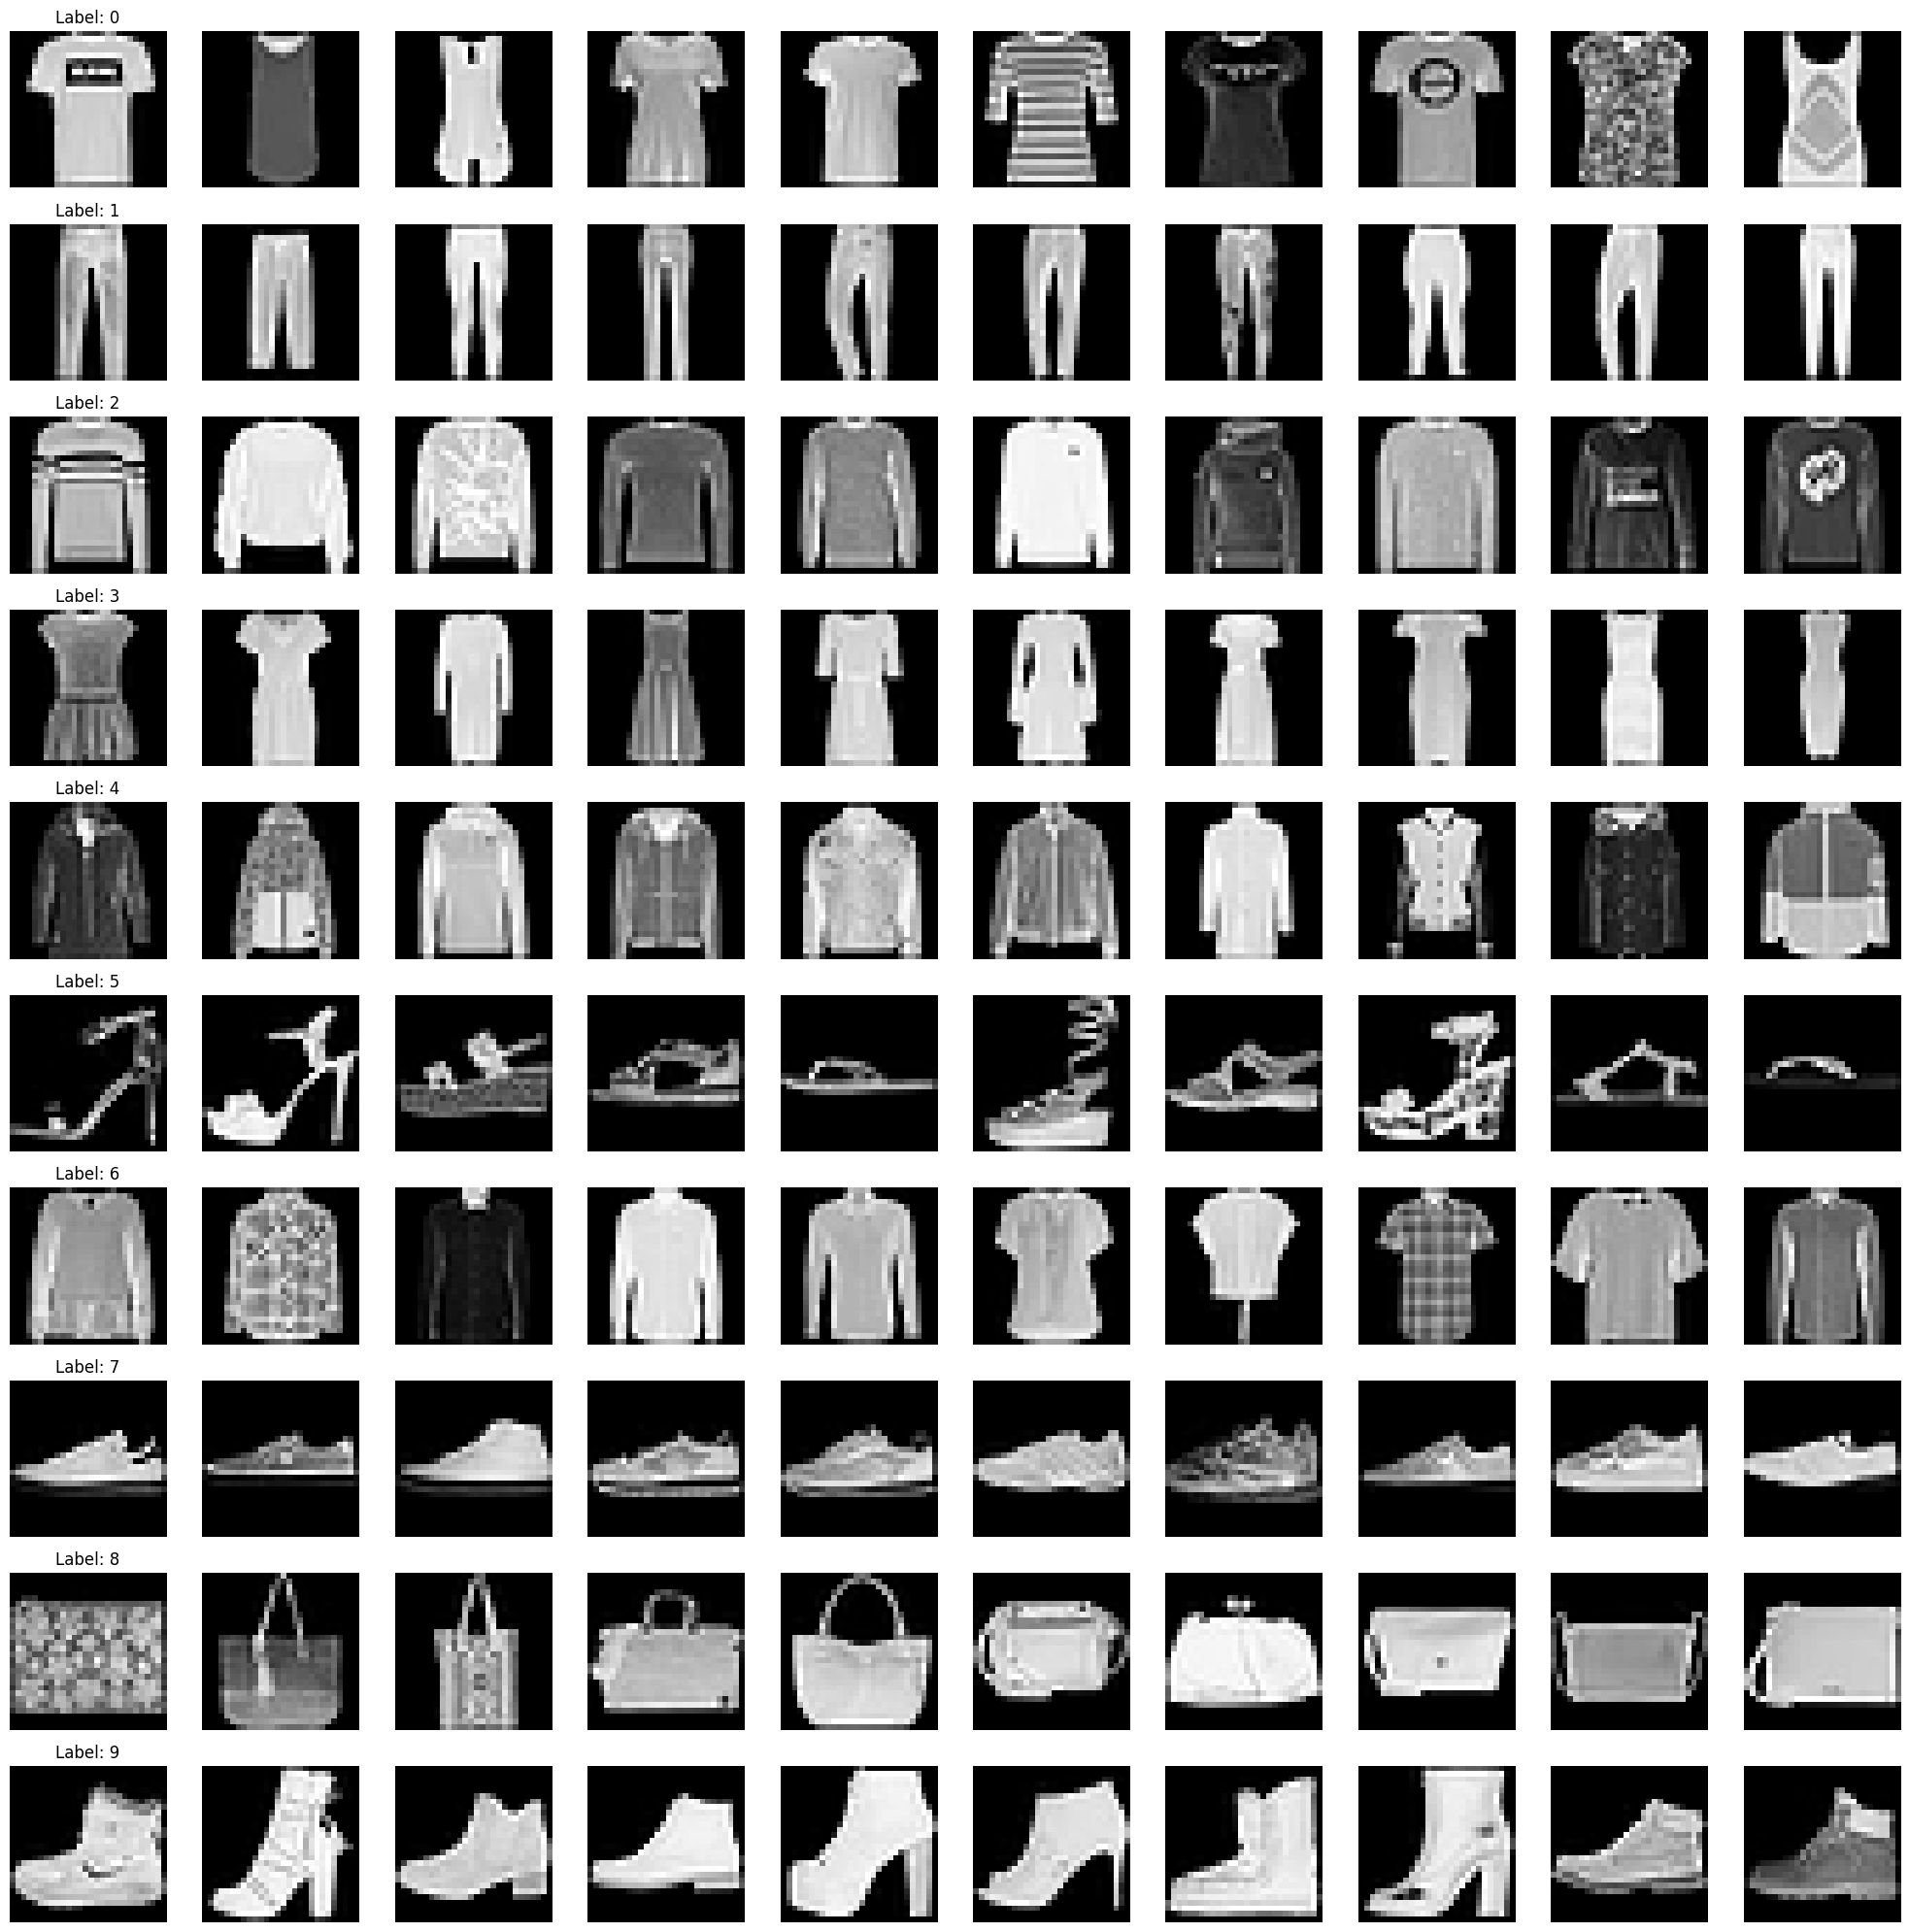

In [7]:
def show_images_by_class(dataset, num_images=10):
    classes = torch.unique(dataset.targets)
    fig, axes = plt.subplots(len(classes), num_images, figsize=(num_images * 2, len(classes) * 2))

    images_per_class = {label.item(): [] for label in classes}

    for img, label in dataset:
        label = label.item()
        if len(images_per_class[label]) < num_images:
            images_per_class[label].append(img)
        if all(len(imgs) >= num_images for imgs in images_per_class.values()):
            break

    for label, images in images_per_class.items():
        for i in range(num_images):
            ax = axes[label, i]
            ax.imshow(images[i].squeeze(), cmap='gray')
            ax.axis('off')
            if i == 0:
                ax.set_title(f'Label: {label}')

    plt.tight_layout()
    plt.show()

show_images_by_class(train_dataset_whole, num_images=10)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
def plot_accuracy_convergence(train_accuracies, test_accuracies, num_epochs, experiment_name):
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)

    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training Accuracy Convergence Graph in {experiment_name}')
    plt.grid(True)


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Test Accuracy Convergence Graph in {experiment_name}')
    plt.grid(True)
    plt.show()

# Without regularization

## Training

In [ ]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [30]:
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_accuracies, test_accuracies = [],[]

correct = 0
total = 0

# Early stopping parameters
patience = 20
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_accuracies.append(100 * correct / total)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss}")

    # Test the model
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracies.append(100 * test_correct / test_total)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model--1.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break



Epoch 1, Train Loss: 0.7546591462117236, Validation Loss: 0.4749126326530538
Epoch 2, Train Loss: 0.4581851712052856, Validation Loss: 0.42240591886195733
Epoch 3, Train Loss: 0.40999953667699446, Validation Loss: 0.39086739782323227
Epoch 4, Train Loss: 0.38085214454698335, Validation Loss: 0.3694536977625908
Epoch 5, Train Loss: 0.36020714726069525, Validation Loss: 0.35501001838673935
Epoch 6, Train Loss: 0.343498609077309, Validation Loss: 0.34481024551898876
Epoch 7, Train Loss: 0.3297604808663305, Validation Loss: 0.33718806505203247
Epoch 8, Train Loss: 0.31810887295629175, Validation Loss: 0.331637331145875
Epoch 9, Train Loss: 0.3075122191301454, Validation Loss: 0.3253283377023453
Epoch 10, Train Loss: 0.2979184207263716, Validation Loss: 0.32023584620749695
Epoch 11, Train Loss: 0.28922834582803375, Validation Loss: 0.3165628139642959
Epoch 12, Train Loss: 0.28120539969460095, Validation Loss: 0.3140183062629497
Epoch 13, Train Loss: 0.2737948767558376, Validation Loss: 0.30

In [33]:
# Load the best model
model.load_state_dict(torch.load('best_model--1.pth',weights_only=True))

# Test the model with the best weights
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = 100 * test_correct / test_total
print(f'Final Test Accuracy with the Best Model: {final_test_accuracy} %')

Final Test Accuracy with the Best Model: 88.24 %


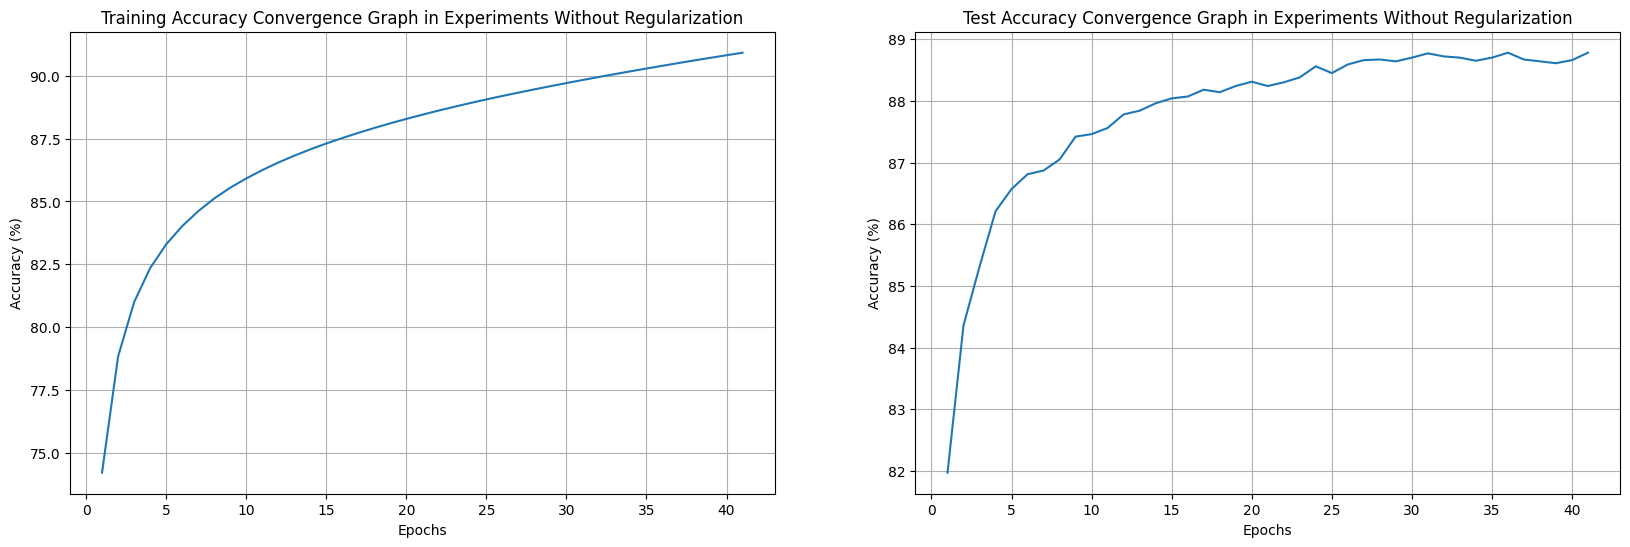

In [34]:
plot_accuracy_convergence(train_accuracies, test_accuracies, epoch+1 , "Experiments Without Regularization")

## Test with saved weights

In [31]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [32]:
model = LeNet5().to(device)
model.load_state_dict(torch.load('best_model--1.pth'))
model.eval()

# Train set accuracy
train_correct = 0
train_total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

train_accuracy = 100 * train_correct / train_total
print(f'Train Accuracy: {train_accuracy}%')

# Test set accuracy
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')



<ipython-input-32-84afa66d553e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model--1.pth'))


Train Accuracy: 91.88703703703703%
Test Accuracy: 88.24%


# With Dropout

## Training

In [ ]:
class LeNet5_dropout(nn.Module):
    def __init__(self):
        super(LeNet5_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x


In [ ]:
model2 = LeNet5_dropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=1e-4)
train_accuracies_dropout, test_accuracies_dropout = [],[]


# Early stopping parameters
patience = 20
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(100):
    model2.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model2(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate train set accuracy
    model2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model2(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    train_accuracies_dropout.append(100 * correct / total)

    # Validate the model
    model2.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model2(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss}")

    # Test the model
    model2.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model2(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracies_dropout.append(100 * test_correct / test_total)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model2.state_dict(), 'best_model_dropout.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break



Epoch 1, Train Loss: 1.2418478583272599, Validation Loss: 0.6027713716030121
Epoch 2, Train Loss: 0.6655004309110731, Validation Loss: 0.49369989747696735
Epoch 3, Train Loss: 0.5684849635402173, Validation Loss: 0.44092282589445725
Epoch 4, Train Loss: 0.5125309573530585, Validation Loss: 0.41444953959038916
Epoch 5, Train Loss: 0.47837926687505006, Validation Loss: 0.3926157976718659
Epoch 6, Train Loss: 0.4500450415633866, Validation Loss: 0.3838453197732885
Epoch 7, Train Loss: 0.4328354825552606, Validation Loss: 0.3724573086550895
Epoch 8, Train Loss: 0.4164967406629386, Validation Loss: 0.3637461782769954
Epoch 9, Train Loss: 0.4048532871132213, Validation Loss: 0.35505209482730704
Epoch 10, Train Loss: 0.39111108933156136, Validation Loss: 0.3476244055844368
Epoch 11, Train Loss: 0.3812362775912782, Validation Loss: 0.3367644614995794
Epoch 12, Train Loss: 0.3733593807048142, Validation Loss: 0.3334165681549843
Epoch 13, Train Loss: 0.362652122197558, Validation Loss: 0.3300326

In [ ]:
# # Load the best model
model2.load_state_dict(torch.load('best_model_dropout.pth',weights_only=True))

# Test the model with the best weights
model2.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = 100 * test_correct / test_total
print(f'Final Test Accuracy with the Best Model: {final_test_accuracy} %')

Final Test Accuracy with the Best Model: 89.97 %


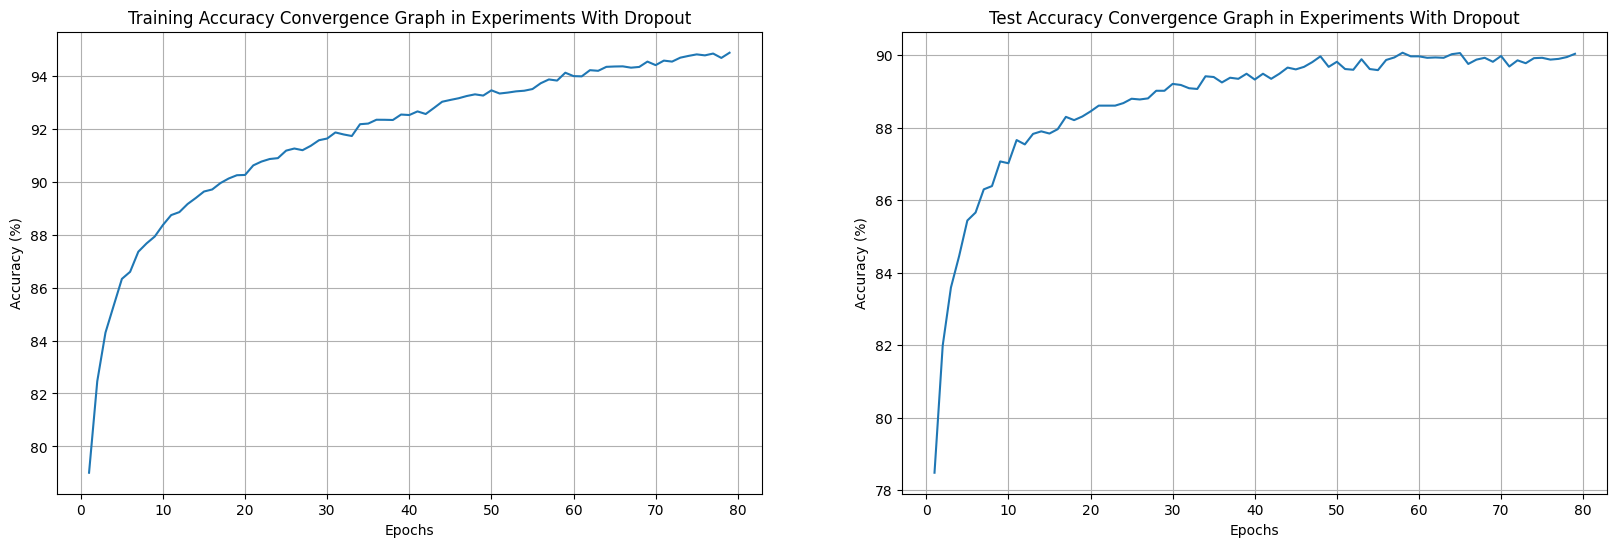

In [ ]:
plot_accuracy_convergence(train_accuracies_dropout, test_accuracies_dropout, epoch+1 , "Experiments With Dropout")

## Test with saved weights

In [13]:
class LeNet5_dropout(nn.Module):
    def __init__(self):
        super(LeNet5_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x


In [14]:
model = LeNet5_dropout().to(device)
model.load_state_dict(torch.load('best_model_dropout.pth'))
model.eval()

# Train set accuracy
train_correct = 0
train_total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

train_accuracy = 100 * train_correct / train_total
print(f'Train Accuracy: {train_accuracy}%')

# Test set accuracy
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')



<ipython-input-14-bcd70881810f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_dropout.pth'))


Train Accuracy: 93.66296296296296%
Test Accuracy: 89.97%


# With Weight Decay


## Training

In [28]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [23]:
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2)
train_accuracies_decay, test_accuracies_decay = [],[]

correct = 0
total = 0

# Early stopping parameters
patience = 20
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_accuracies_decay.append(100 * correct / total)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss}")

    # Test the model
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracies_decay.append(100 * test_correct / test_total)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_weight_decay4.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break



Epoch 1, Train Loss: 0.7507887768660676, Validation Loss: 0.45630490906695104
Epoch 2, Train Loss: 0.44158634875340486, Validation Loss: 0.3994351257669165
Epoch 3, Train Loss: 0.3936371831532338, Validation Loss: 0.37503593652806383
Epoch 4, Train Loss: 0.36647123620973376, Validation Loss: 0.3593287116035502
Epoch 5, Train Loss: 0.34713086404647875, Validation Loss: 0.34815708341750695
Epoch 6, Train Loss: 0.33153378433808334, Validation Loss: 0.3390677514228415
Epoch 7, Train Loss: 0.318941126255345, Validation Loss: 0.33107710106575744
Epoch 8, Train Loss: 0.30826346403190874, Validation Loss: 0.32329017526291787
Epoch 9, Train Loss: 0.29916219738139926, Validation Loss: 0.31664643737863984
Epoch 10, Train Loss: 0.29091378679207713, Validation Loss: 0.3122045768702284
Epoch 11, Train Loss: 0.28361439461250443, Validation Loss: 0.30763552480555595
Epoch 12, Train Loss: 0.2771961886029673, Validation Loss: 0.3053206668255177
Epoch 13, Train Loss: 0.2712199315781842, Validation Loss: 

In [24]:
# Load the best model
model.load_state_dict(torch.load('best_model_weight_decay4.pth',weights_only=True))

# Test the model with the best weights
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = 100 * test_correct / test_total
print(f'Final Test Accuracy with the Best Model: {final_test_accuracy} %')

Final Test Accuracy with the Best Model: 89.81 %


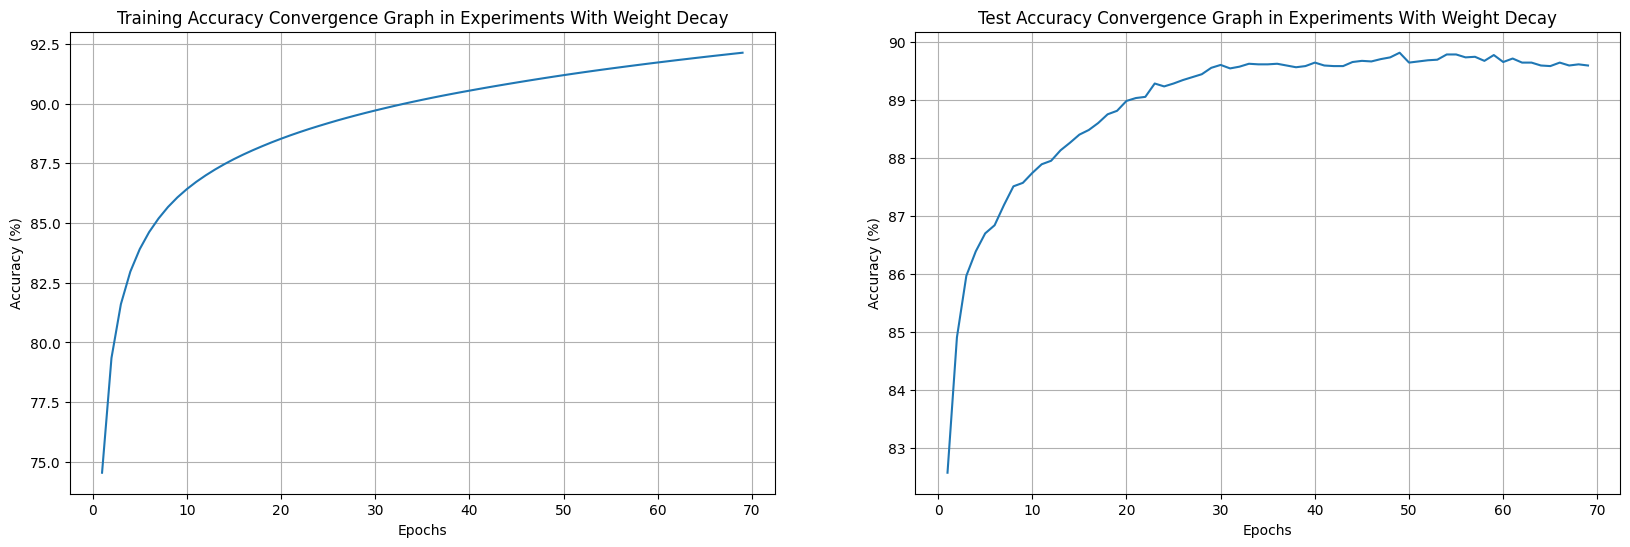

In [25]:
plot_accuracy_convergence(train_accuracies_decay, test_accuracies_decay, epoch+1 , "Experiments With Weight Decay")

## Test with saved weights

In [26]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [27]:
model = LeNet5().to(device)
model.load_state_dict(torch.load('best_model_weight_decay4.pth',weights_only=True))
model.eval()

# Train set accuracy
train_correct = 0
train_total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

train_accuracy = 100 * train_correct / train_total
print(f'Train Accuracy: {train_accuracy}%')

# Test set accuracy
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f'Test Accuracy: {test_accuracy}%')



Train Accuracy: 93.76481481481481%
Test Accuracy: 89.81%


# With Batch Normalization


## Train

In [10]:
class LeNet5_BN(nn.Module):
    def __init__(self):
        super(LeNet5_BN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        # x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        # x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
model3 = LeNet5_BN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=1e-4)
train_accuracies_BN, test_accuracies_BN = [],[]

correct = 0
total = 0

# Early stopping parameters
patience = 20
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(100):
    model3.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model3(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_accuracies_BN.append(100 * correct / total)

    # Validate the model
    model3.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model3(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss}")

    # Test the model
    model3.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model3(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracies_BN.append(100 * test_correct / test_total)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model3.state_dict(), 'best_model_BN.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break



Epoch 1, Train Loss: 1.0598174337809685, Validation Loss: 0.5751654943253132
Epoch 2, Train Loss: 0.5001513323795174, Validation Loss: 0.45284916365400274
Epoch 3, Train Loss: 0.4189122783911737, Validation Loss: 0.40169812199917243
Epoch 4, Train Loss: 0.3784849804724562, Validation Loss: 0.3745037279230483
Epoch 5, Train Loss: 0.3536504986232491, Validation Loss: 0.35737628251948256
Epoch 6, Train Loss: 0.3363646358534058, Validation Loss: 0.3452134864761474
Epoch 7, Train Loss: 0.3231557342819693, Validation Loss: 0.33626174546302634
Epoch 8, Train Loss: 0.3124340892332425, Validation Loss: 0.3291284831914496
Epoch 9, Train Loss: 0.30334193870354603, Validation Loss: 0.323383371246622
Epoch 10, Train Loss: 0.2954879039059883, Validation Loss: 0.31893464003471617
Epoch 11, Train Loss: 0.2885079207296055, Validation Loss: 0.3151967918619196
Epoch 12, Train Loss: 0.28222823358401306, Validation Loss: 0.31191711159462626
Epoch 13, Train Loss: 0.2764551748314175, Validation Loss: 0.30907

In [ ]:
# Load the best model
model3.load_state_dict(torch.load('best_model_BN.pth',weights_only=True))

# Test the model with the best weights
model3.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model3(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

final_test_accuracy = 100 * test_correct / test_total
print(f'Final Test Accuracy with the Best Model: {final_test_accuracy} %')

Final Test Accuracy with the Best Model: 89.55 %


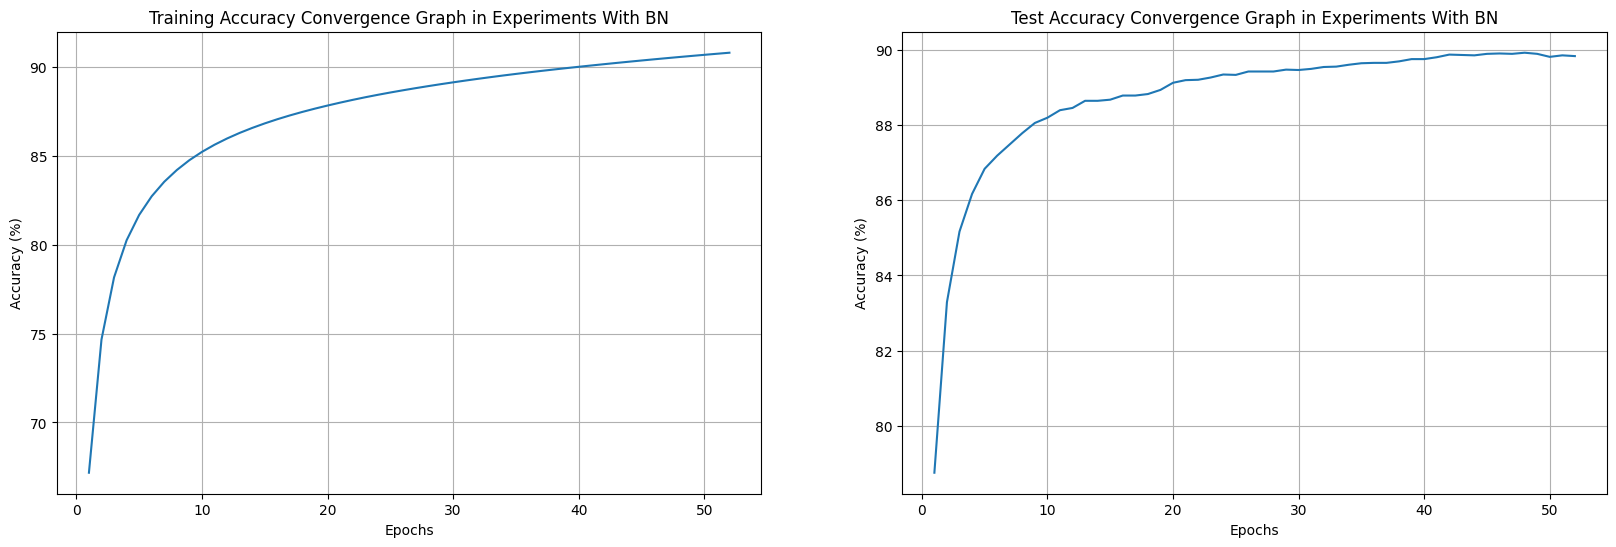

In [ ]:
plot_accuracy_convergence(train_accuracies_BN, test_accuracies_BN, epoch+1 , "Experiments With BN")

## Test with saved weights